In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('df_metrics_CGM_biochem_demographics.csv')

# Display basic info about the dataframe
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"First few rows:")
print(df.head())

DataFrame shape: (736, 36)
Columns: ['Patient_ID', 'TIR', 'TBR', 'TAR', 'CV', 'A1c_mean', 'A1c_SD', 'Sex', 'Number_of_days_with_measures', 'Number_of_measurements', 'Number_of_biochemical_parameters', 'Number_of_diagnostics', 'Age', 'Alanine transaminase (GPT)_mean', 'Albumin (urine)_mean', 'Chlorine_mean', 'Creatinine_mean', 'Creatinine (urine)_mean', 'Gamma-glutamyl Transferase (GGT)_mean', 'Glucose_mean', 'HDL cholesterol_mean', 'Potassium_mean', 'Sodium_mean', 'Thyrotropin (TSH)_mean', 'Total cholesterol_mean', 'Triglycerides_mean', 'Uric acid_mean', 'Hypothyroidism', 'Hypertension', 'Diabetes with ophthalmic manifestations', 'Lipid metabolism', 'Weight', 'Allergic Rhinitis', 'Diabetes with renal manifestations', 'Asthma', 'Diabetes with neurological manifestations']
First few rows:
  Patient_ID        TIR        TBR        TAR        CV  A1c_mean    A1c_SD  \
0  LIB193263  52.567473   1.941828  45.490699  0.352605       NaN       NaN   
1  LIB193264  62.474335   8.033748  29.49191

In [2]:
print("Class distribution:")
print(df['Hypothyroidism'].value_counts())
print(df['Hypertension'].value_counts()) 
print(df['Diabetes with ophthalmic manifestations'].value_counts())
print(df['Lipid metabolism'].value_counts())

Class distribution:
Hypothyroidism
0    639
1     97
Name: count, dtype: int64
Hypertension
0    667
1     69
Name: count, dtype: int64
Diabetes with ophthalmic manifestations
0    659
1     77
Name: count, dtype: int64
Lipid metabolism
0    683
1     53
Name: count, dtype: int64


In [3]:
print("Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head())

Missing values per column:
Chlorine_mean              313
Number_of_diagnostics      225
A1c_SD                      30
Uric acid_mean              28
Creatinine (urine)_mean     23
dtype: int64


In [4]:
# Create a new dataframe by dropping the high-missingness columns
df_clean = df.drop(columns=['Chlorine_mean', 'Number_of_diagnostics'])

# Keep only complete cases (rows with no missing values)
df_complete = df_clean.dropna()

print(f"Original dataframe shape: {df.shape}")
print(f"After dropping high-missing columns: {df_clean.shape}")
print(f"After keeping only complete cases: {df_complete.shape}")
print(f"Final patient count: {len(df_complete)}")

# Show missing values in the final dataset to verify
print("\nMissing values in final dataset:")
print(df_complete.isnull().sum().sum())  # Should be 0

Original dataframe shape: (736, 36)
After dropping high-missing columns: (736, 34)
After keeping only complete cases: (693, 34)
Final patient count: 693

Missing values in final dataset:
0


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc, 
                             confusion_matrix, brier_score_loss, roc_curve)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

def prepare_data(df, target_col, test_size=0.3, random_state=42, apply_smote=False):
    """
    Prepare data for prediction and inference, ensuring that the target itself
    and all other condition columns are NOT included as predictors.
    """
    # List of all condition columns
    condition_cols = [
        'Hypothyroidism', 'Hypertension', 'Diabetes with ophthalmic manifestations',
        'Lipid metabolism', 'Weight', 'Allergic Rhinitis', 
        'Diabetes with renal manifestations', 'Asthma', 
        'Diabetes with neurological manifestations'
    ]

    # Columns to remove from predictors: Patient_ID, Sex, all other conditions
    cols_to_remove = ['Patient_ID', 'Sex'] + [c for c in condition_cols if c != target_col]

    # Start from df, drop target column if somehow still present
    X = df.drop(columns=cols_to_remove + [target_col] + ["TAR"], errors='ignore')
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Keep original (unscaled) training data for OR calculation
    X_train_original = X_train.copy()
    y_train_original = y_train.copy()

    # Standardize
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE if needed
    y_train_pred = y_train.copy()
    if apply_smote:
        sm_obj = SMOTE(random_state=random_state)
        X_train_scaled, y_train_pred = sm_obj.fit_resample(X_train_scaled, y_train_pred)
        print(f"Applied SMOTE: Training samples for prediction model: {len(y_train_pred)}")
        print(f"Original training samples preserved for inference: {len(y_train_original)}")

    return {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'X_train_original': X_train_original,
        'y_train_original': y_train_original,
        'y_train_pred': y_train_pred,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': X.columns
    }



# ==============================
# CLINICAL EVALUATION FUNCTION
# ==============================
def clinical_evaluation(model, X_test, y_test):
    """
    Comprehensive clinical evaluation metrics
    """
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    brier = brier_score_loss(y_test, y_pred_proba)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]

    # Threshold analysis
    threshold_results = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5]:
        y_pred = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        threshold_results[threshold] = {
            'sensitivity': sensitivity,
            'specificity': specificity,
            'ppv': ppv,
            'npv': npv,
            'patients_identified': y_pred.sum()
        }

    return {
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'brier_score': brier,
        'optimal_threshold': optimal_threshold,
        'optimal_sensitivity': tpr[optimal_idx],
        'optimal_specificity': 1 - fpr[optimal_idx],
        'threshold_analysis': threshold_results
    }

# ==============================
# ODDS RATIOS CALCULATION (USES ORIGINAL DATA)
# ==============================
def calculate_odds_ratios(X_train_original, y_train_original, feature_names, 
                         alpha=0.05, multiple_testing_correction='fdr_bh'):
    """
    Calculate odds ratios using statsmodels for proper statistical inference.
    
    FIXES APPLIED:
    1. Uses ORIGINAL training data (NOT SMOTE-resampled) for valid inference
    2. Uses UNSCALED data so odds ratios are on clinical scale
    3. Applies multiple testing correction (FDR by default)
    
    Parameters:
    -----------
    X_train_original : array-like or DataFrame
        ORIGINAL training features on ORIGINAL SCALE (not SMOTE, not standardized)
    y_train_original : array-like
        ORIGINAL training labels (not SMOTE-resampled)
    feature_names : list
        Names of features
    alpha : float
        Significance level for confidence intervals (default: 0.05 for 95% CI)
    multiple_testing_correction : str
        Method for multiple testing correction. Options: 'bonferroni', 'fdr_bh' (default), 
        'fdr_by', 'holm', or None
    
    Returns:
    --------
    DataFrame with odds ratios, confidence intervals, and adjusted p-values
    statsmodels Logit result object
    """
    # Convert to DataFrame if needed
    if not isinstance(X_train_original, pd.DataFrame):
        X_train_df = pd.DataFrame(X_train_original, columns=feature_names)
    else:
        X_train_df = X_train_original.copy()
    
    # Add constant term (intercept)
    X_with_const = sm.add_constant(X_train_df)
    
    # Fit model using statsmodels for proper statistical inference
    model_sm = sm.Logit(y_train_original, X_with_const)
    try:
        result_sm = model_sm.fit_regularized(method='l1', alpha=0.1)
    except np.linalg.LinAlgError:
        print("Warning: Singular matrix detected. Using regularized fit.")
        result_sm = model_sm.fit_regularized(method='l1', alpha=0.1, maxiter=1000)
    
    # Get confidence intervals from statsmodels (properly calculated)
    conf_int = result_sm.conf_int(alpha=alpha)
    
    # Extract parameters (exclude intercept)
    params = result_sm.params[1:]  # Exclude const
    conf_int_features = conf_int.iloc[1:, :]  # Exclude const
    pvalues = result_sm.pvalues[1:]  # Exclude const
    bse = result_sm.bse[1:]  # Standard errors
    
    # Apply multiple testing correction
    if multiple_testing_correction is not None:
        reject, pvals_corrected, _, _ = multipletests(
            pvalues, alpha=alpha, method=multiple_testing_correction
        )
    else:
        reject = pvalues < alpha
        pvals_corrected = pvalues
    
    # Calculate odds ratios and confidence intervals
    odds_ratios = np.exp(params)
    ci_lower_exp = np.exp(conf_int_features.iloc[:, 0])
    ci_upper_exp = np.exp(conf_int_features.iloc[:, 1])
    
    # Calculate z-scores
    z_scores = params / bse
    
    # Create results dataframe
    df_results = pd.DataFrame({
        'feature': feature_names,
        'coefficient': params.values,
        'odds_ratio': odds_ratios.values,
        'se': bse.values,
        'z_score': z_scores.values,
        'p_value': pvalues.values,
        'p_value_adjusted': pvals_corrected,
        'ci_lower': ci_lower_exp.values,
        'ci_upper': ci_upper_exp.values,
        'significant_raw': pvalues.values < alpha,
        'significant_adjusted': reject
    }).sort_values('odds_ratio', key=lambda x: np.abs(np.log(x)), ascending=False)
    
    print("\n" + "="*70)
    print("*** ODDS RATIOS INTERPRETATION ***")
    print("="*70)
    print("These odds ratios represent the multiplicative change in odds")
    print("for a 1-UNIT increase in each feature on its ORIGINAL CLINICAL SCALE.")
    print("Example: If Age has OR=1.05, each additional year increases odds by 5%")
    print("\nIMPORTANT METHODOLOGICAL NOTES:")
    print("- Calculated on ORIGINAL data (pre-SMOTE) for valid inference")
    print("- Uses UNSCALED features so ORs are on clinical scale")
    print("- Confidence intervals from statsmodels (proper variance-covariance)")
    if multiple_testing_correction:
        print(f"- Multiple testing correction applied: {multiple_testing_correction}")
        print(f"  (Testing {len(feature_names)} features simultaneously)")
    print("="*70)
    
    return df_results, result_sm

# ==============================
# CONVERT COEFFICIENTS TO ORIGINAL SCALE
# ==============================
def coefficients_to_original_scale(model_sklearn, scaler, feature_names):
    """
    Convert coefficients from standardized scale back to original scale.
    
    This allows interpretation of the prediction model's coefficients
    on the original clinical scale, bridging the gap between the
    statsmodels inference model and sklearn prediction model.
    
    Parameters:
    -----------
    model_sklearn : LogisticRegression
        Trained sklearn model on standardized data
    scaler : StandardScaler
        Fitted scaler used for standardization
    feature_names : list
        Names of features
    
    Returns:
    --------
    DataFrame with coefficients and odds ratios on original scale
    """
    # Get coefficients from standardized model
    coef_scaled = model_sklearn.coef_[0]
    
    # Convert to original scale
    # When X was scaled: X_scaled = (X - mean) / std
    # So: coef_original = coef_scaled / std
    coef_original = coef_scaled / scaler.scale_
    
    # Also adjust intercept
    # intercept_original = intercept_scaled - sum(coef_scaled * mean / std)
    intercept_original = model_sklearn.intercept_[0] - np.sum(coef_scaled * scaler.mean_ / scaler.scale_)
    
    # Calculate odds ratios on original scale
    odds_ratios_original = np.exp(coef_original)
    
    df_coef = pd.DataFrame({
        'feature': feature_names,
        'coef_scaled': coef_scaled,
        'coef_original': coef_original,
        'odds_ratio_original': odds_ratios_original
    }).sort_values('odds_ratio_original', key=lambda x: np.abs(np.log(x)), ascending=False)
    
    print("\n" + "="*70)
    print("*** PREDICTION MODEL COEFFICIENTS (CONVERTED TO ORIGINAL SCALE) ***")
    print("="*70)
    print("These represent the sklearn prediction model's learned coefficients")
    print("converted back to the original clinical scale for interpretation.")
    print("\nNOTE: These may differ from statsmodels odds ratios because:")
    print("- Prediction model was trained on SMOTE-resampled data")
    print("- Different optimization objectives (sklearn vs statsmodels)")
    print("="*70)
    
    return df_coef, intercept_original

# ==============================
# PLOTTING FUNCTIONS
# ==============================
def plot_comprehensive_evaluation(condition_name, y_test, y_pred_proba, eval_results):
    """
    Create comprehensive evaluation plots
    """
    fig = plt.figure(figsize=(20, 5))

    # ROC Curve
    plt.subplot(1, 4, 1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC={eval_results["roc_auc"]:.3f})')
    plt.plot([0,1],[0,1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{condition_name}\nROC Curve')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1, 4, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR (AUC={eval_results["pr_auc"]:.3f})')
    plt.axhline(y=y_test.mean(), color='red', linestyle='--', label='Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{condition_name}\nPrecision-Recall')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')

    # Calibration
    plt.subplot(1, 4, 3)
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_proba, n_bins=10, strategy='uniform'
    )
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Model')
    plt.plot([0,1],[0,1], "k:", label='Perfect')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'{condition_name}\nCalibration (Brier={eval_results["brier_score"]:.3f})')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')

    # Threshold analysis
    plt.subplot(1, 4, 4)
    thresholds = list(eval_results['threshold_analysis'].keys())
    sens = [eval_results['threshold_analysis'][t]['sensitivity'] for t in thresholds]
    spec = [eval_results['threshold_analysis'][t]['specificity'] for t in thresholds]
    plt.plot(thresholds, sens, 'o-', label='Sensitivity', color='blue')
    plt.plot(thresholds, spec, 'o-', label='Specificity', color='red')
    plt.axvline(eval_results['optimal_threshold'], color='black', linestyle='--',
                label=f'Optimal: {eval_results["optimal_threshold"]:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Performance')
    plt.title(f'{condition_name}\nThreshold Analysis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_odds_ratios(condition_name, odds_results, top_n=10, use_adjusted_p=True):
    """
    Forest plot of odds ratios with confidence intervals
    """
    top_features = odds_results.head(top_n).sort_values('odds_ratio', ascending=True)
    y_pos = np.arange(len(top_features))
    
    plt.figure(figsize=(12, 8))
    plt.errorbar(top_features['odds_ratio'], y_pos,
                 xerr=[top_features['odds_ratio'] - top_features['ci_lower'],
                       top_features['ci_upper'] - top_features['odds_ratio']],
                 fmt='o', color='black', ecolor='red', capsize=5)
    plt.axvline(1, color='gray', linestyle='--', alpha=0.7, label='No effect')
    plt.yticks(y_pos, top_features['feature'])
    plt.xlabel('Odds Ratio (95% CI) - Per 1-Unit Increase on Clinical Scale')
    
    p_col = 'p_value_adjusted' if use_adjusted_p else 'p_value'
    p_label = 'Adjusted' if use_adjusted_p else 'Unadjusted'
    plt.title(f'{condition_name}\nTop {top_n} Predictors by Effect Size\n(From Original Unscaled Data, {p_label} p-values)')
    plt.xscale('log')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add significance stars based on chosen p-value
    for i, (_, row) in enumerate(top_features.iterrows()):
        sig = ''
        p_val = row[p_col]
        if p_val < 0.001: 
            sig = '***'
        elif p_val < 0.01: 
            sig = '**'
        elif p_val < 0.05: 
            sig = '*'
        
        if sig:
            plt.text(row['ci_upper'] * 1.1, i, sig, va='center', fontweight='bold', fontsize=12)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==============================
# RUN FULL ANALYSIS FOR A CONDITION
# ==============================
def run_analysis(df, condition, apply_smote=True, multiple_testing_correction='fdr_bh'):
    """
    Run complete analysis pipeline for a single condition.
    
    FIXED VERSION WITH ALL CRITICAL AND MAJOR ISSUES RESOLVED:
    1. Scaler fit on ORIGINAL data before SMOTE (prevents data leakage)
    2. Odds ratios calculated on ORIGINAL UNSCALED data (proper clinical interpretation)
    3. Multiple testing correction applied (controls Type I error)
    4. Coefficient conversion provided (bridges statsmodels and sklearn models)
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with features and target (features MUST be on original clinical scale)
    condition : str
        Name of target column (condition to predict)
    apply_smote : bool
        Whether to apply SMOTE for handling class imbalance
    multiple_testing_correction : str
        Method for multiple testing correction ('fdr_bh', 'bonferroni', None)
    """
    print(f"\n{'='*80}\nANALYSIS FOR: {condition.upper()}\n{'='*80}")
    
    # Prepare data - now with fixed scaling order
    data = prepare_data(df, condition, apply_smote=apply_smote)
    
    print(f"\nOriginal training samples: {len(data['y_train_original'])}")
    print(f"Prediction training samples (after SMOTE): {len(data['y_train_pred'])}")
    print(f"Test samples: {len(data['y_test'])}")
    print(f"Class distribution (original train): {dict(pd.Series(data['y_train_original']).value_counts())}")
    print(f"Class distribution (SMOTE train): {dict(pd.Series(data['y_train_pred']).value_counts())}")
    
    # Calculate odds ratios using ORIGINAL UNSCALED data for valid inference
    print("\n[1/4] Calculating odds ratios on ORIGINAL UNSCALED training data...")
    odds_df, model_statsmodels = calculate_odds_ratios(
        data['X_train_original'], 
        data['y_train_original'], 
        data['feature_names'],
        multiple_testing_correction=multiple_testing_correction
    )
    
    # Train sklearn model on SMOTE-resampled SCALED data for predictions
    print("\n[2/4] Training prediction model on SMOTE-resampled SCALED data...")
    model_sklearn = LogisticRegression(
        penalty='l2', 
        C=0.1,  # Stronger regularization
        max_iter=1000,
        random_state=42,
        solver='lbfgs'
    )
    model_sklearn.fit(data['X_train_scaled'], data['y_train_pred'])
    
    # Convert sklearn coefficients to original scale for interpretation
    print("\n[3/4] Converting prediction model coefficients to original scale...")
    coef_df, intercept_original = coefficients_to_original_scale(
        model_sklearn, 
        data['scaler'], 
        data['feature_names']
    )
    
    # Evaluate on test set
    print("\n[4/4] Evaluating on test set...")
    eval_results = clinical_evaluation(model_sklearn, data['X_test_scaled'], data['y_test'])
    
    print(f"\n--- Performance Metrics ---")
    print(f"ROC-AUC: {eval_results['roc_auc']:.3f}")
    print(f"PR-AUC: {eval_results['pr_auc']:.3f}")
    print(f"Brier Score: {eval_results['brier_score']:.3f}")
    print(f"Optimal Threshold: {eval_results['optimal_threshold']:.3f}")
    print(f"  - Sensitivity: {eval_results['optimal_sensitivity']:.3f}")
    print(f"  - Specificity: {eval_results['optimal_specificity']:.3f}")
    
    # Display top predictors with adjusted p-values
    top_features = odds_df.head(10)
    print("\n--- Top 10 Predictors (Statistical Inference Model) ---")
    display_cols = ['feature', 'odds_ratio', 'ci_lower', 'ci_upper', 
                    'p_value', 'p_value_adjusted', 'significant_adjusted']
    print(top_features[display_cols].to_string())
    
    # Display prediction model coefficients
    print("\n--- Top 10 Predictors (Prediction Model on Original Scale) ---")
    print(coef_df.head(10).to_string())
    
    # Generate plots
    plot_comprehensive_evaluation(condition, data['y_test'], eval_results['y_pred_proba'], eval_results)
    plot_odds_ratios(condition, odds_df, top_n=10, use_adjusted_p=True)
    
    return {
        'model_sklearn': model_sklearn,
        'model_statsmodels': model_statsmodels,
        'scaler': data['scaler'],
        'eval_results': eval_results,
        'odds_df': odds_df,
        'coef_df': coef_df,
        'intercept_original': intercept_original,
        'feature_names': data['feature_names'],
        'n_original_train': len(data['y_train_original']),
        'n_smote_train': len(data['y_train_pred'])
    }


ANALYSIS FOR: HYPOTHYROIDISM
Applied SMOTE: Training samples for prediction model: 842
Original training samples preserved for inference: 485

Original training samples: 485
Prediction training samples (after SMOTE): 842
Test samples: 208
Class distribution (original train): {0: np.int64(421), 1: np.int64(64)}
Class distribution (SMOTE train): {0: np.int64(421), 1: np.int64(421)}

[1/4] Calculating odds ratios on ORIGINAL UNSCALED training data...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.31756555321901764
            Iterations: 114
            Function evaluations: 152
            Gradient evaluations: 114

*** ODDS RATIOS INTERPRETATION ***
These odds ratios represent the multiplicative change in odds
for a 1-UNIT increase in each feature on its ORIGINAL CLINICAL SCALE.
Example: If Age has OR=1.05, each additional year increases odds by 5%

IMPORTANT METHODOLOGICAL NOTES:
- Calculated on ORIGINAL data (pre-SMOTE) for valid inference

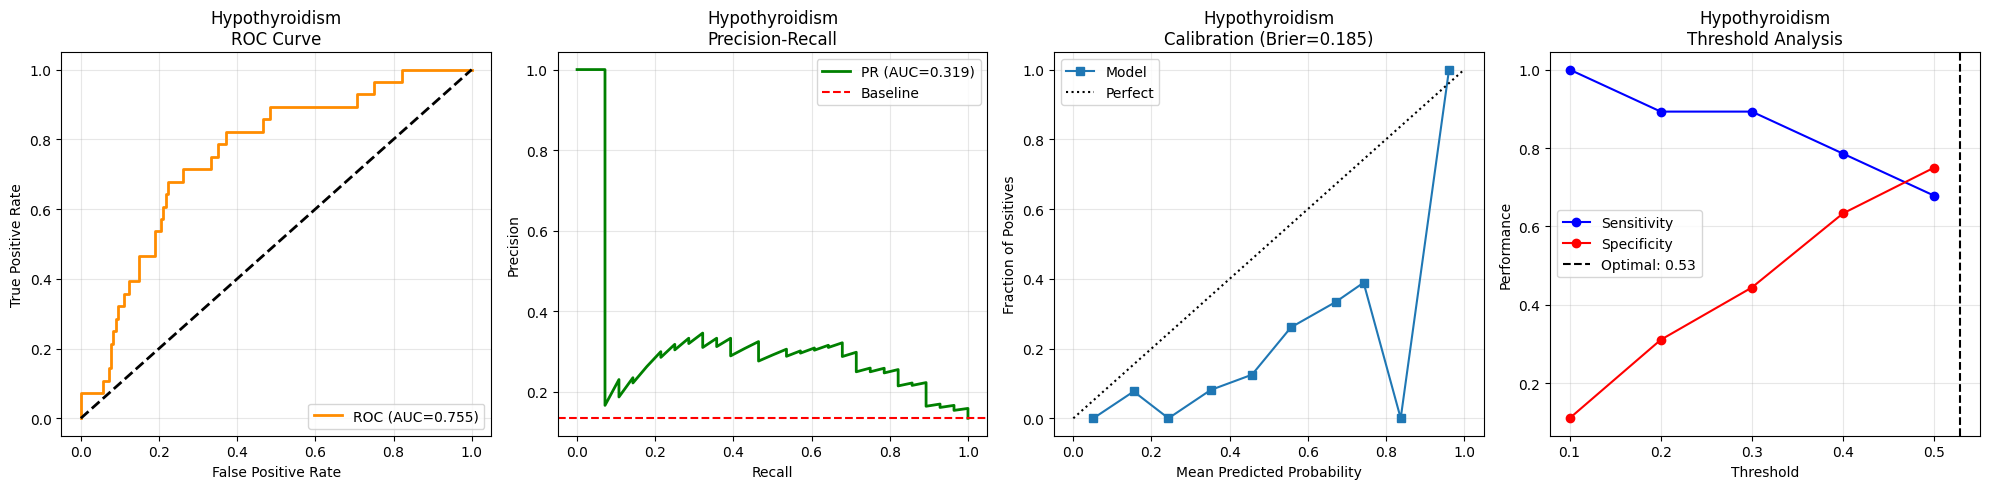

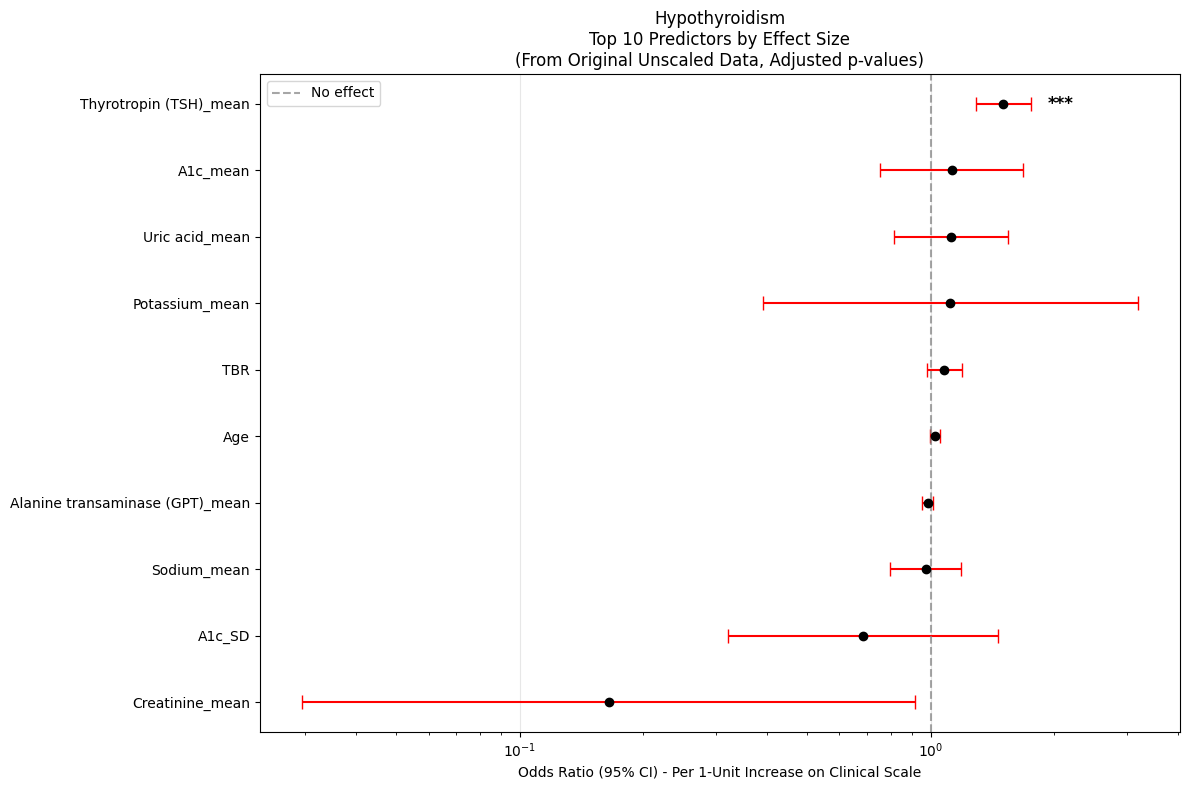


ANALYSIS FOR: HYPERTENSION
Applied SMOTE: Training samples for prediction model: 876
Original training samples preserved for inference: 485

Original training samples: 485
Prediction training samples (after SMOTE): 876
Test samples: 208
Class distribution (original train): {0: np.int64(438), 1: np.int64(47)}
Class distribution (SMOTE train): {0: np.int64(438), 1: np.int64(438)}

[1/4] Calculating odds ratios on ORIGINAL UNSCALED training data...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.23905955889787156
            Iterations: 193
            Function evaluations: 230
            Gradient evaluations: 193

*** ODDS RATIOS INTERPRETATION ***
These odds ratios represent the multiplicative change in odds
for a 1-UNIT increase in each feature on its ORIGINAL CLINICAL SCALE.
Example: If Age has OR=1.05, each additional year increases odds by 5%

IMPORTANT METHODOLOGICAL NOTES:
- Calculated on ORIGINAL data (pre-SMOTE) for valid inference
-

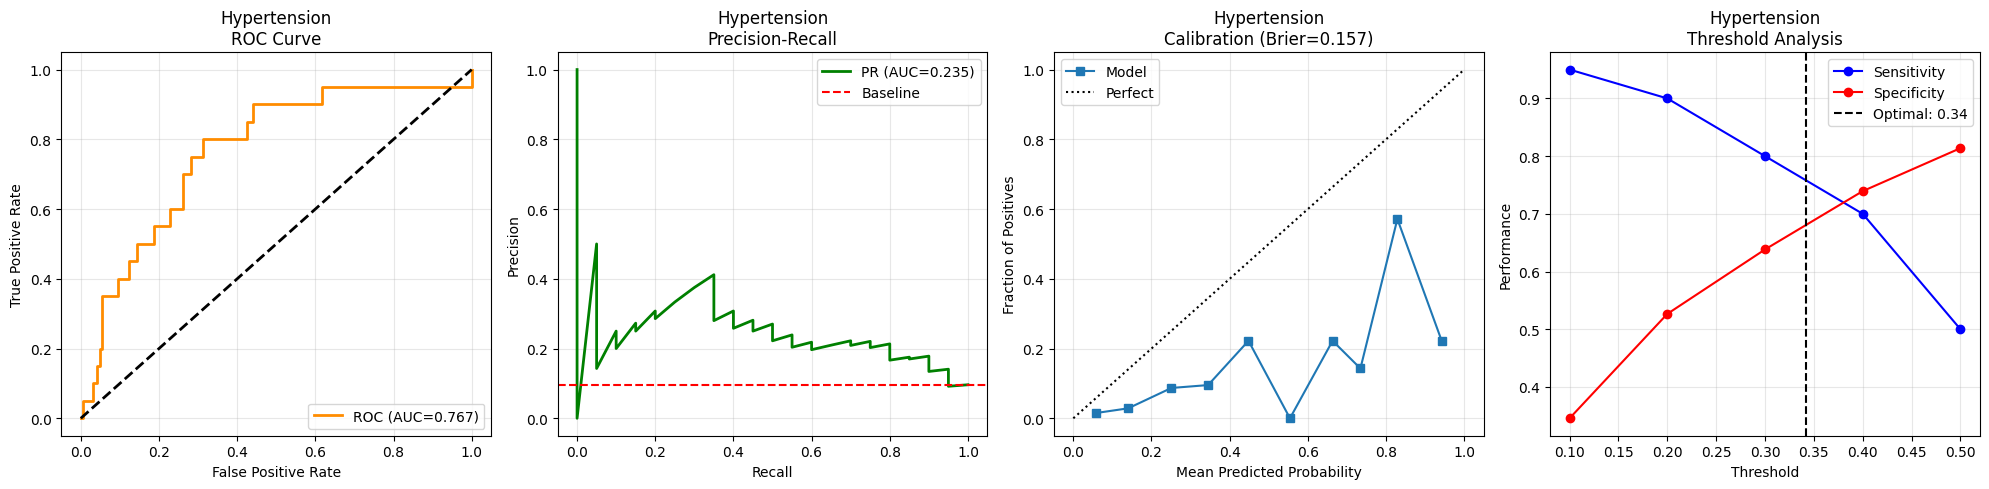

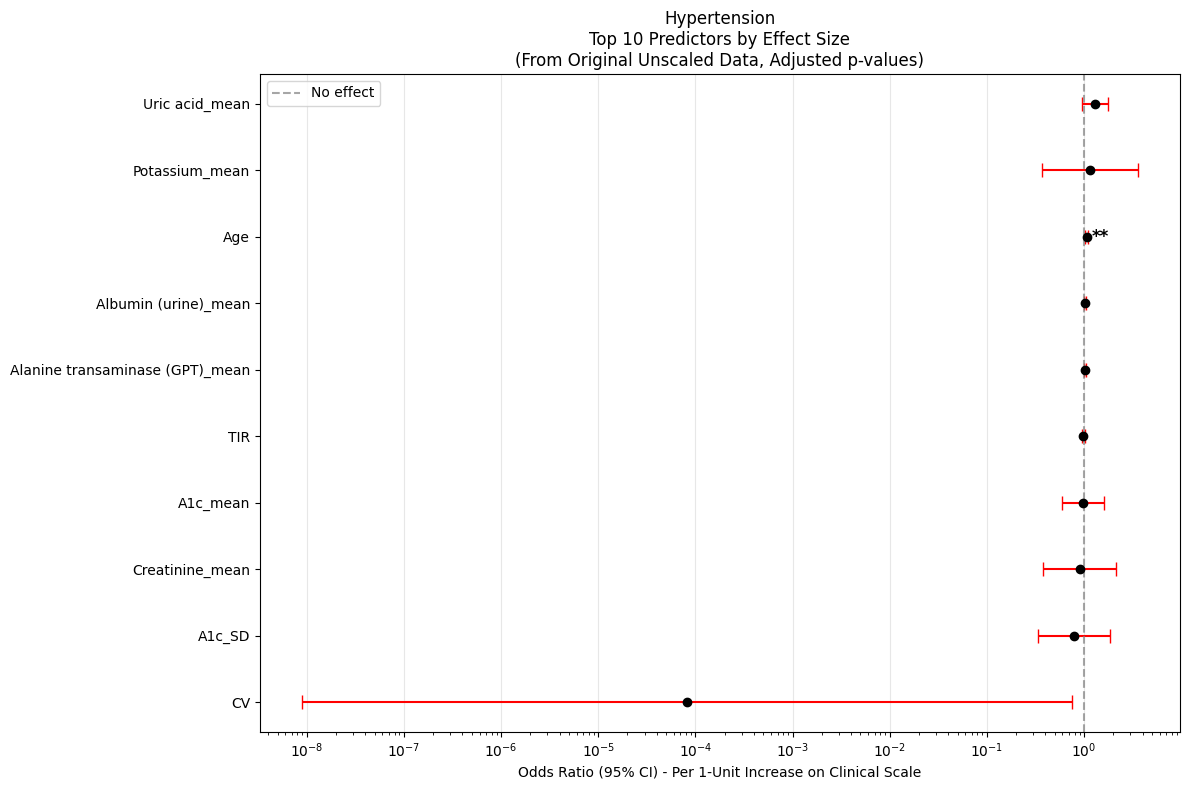


ANALYSIS FOR: DIABETES WITH OPHTHALMIC MANIFESTATIONS
Applied SMOTE: Training samples for prediction model: 866
Original training samples preserved for inference: 485

Original training samples: 485
Prediction training samples (after SMOTE): 866
Test samples: 208
Class distribution (original train): {0: np.int64(433), 1: np.int64(52)}
Class distribution (SMOTE train): {0: np.int64(433), 1: np.int64(433)}

[1/4] Calculating odds ratios on ORIGINAL UNSCALED training data...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.293720715216483
            Iterations: 116
            Function evaluations: 155
            Gradient evaluations: 116

*** ODDS RATIOS INTERPRETATION ***
These odds ratios represent the multiplicative change in odds
for a 1-UNIT increase in each feature on its ORIGINAL CLINICAL SCALE.
Example: If Age has OR=1.05, each additional year increases odds by 5%

IMPORTANT METHODOLOGICAL NOTES:
- Calculated on ORIGINAL data (pre-SMO

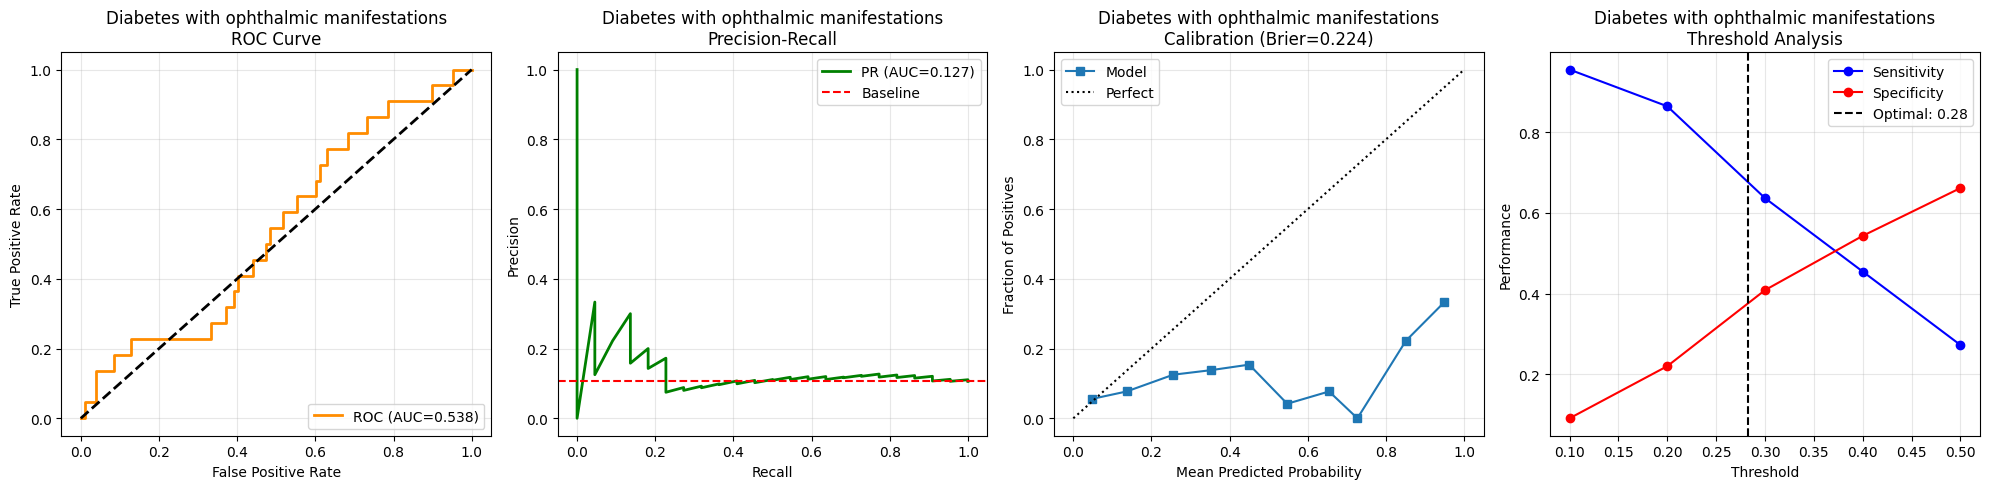

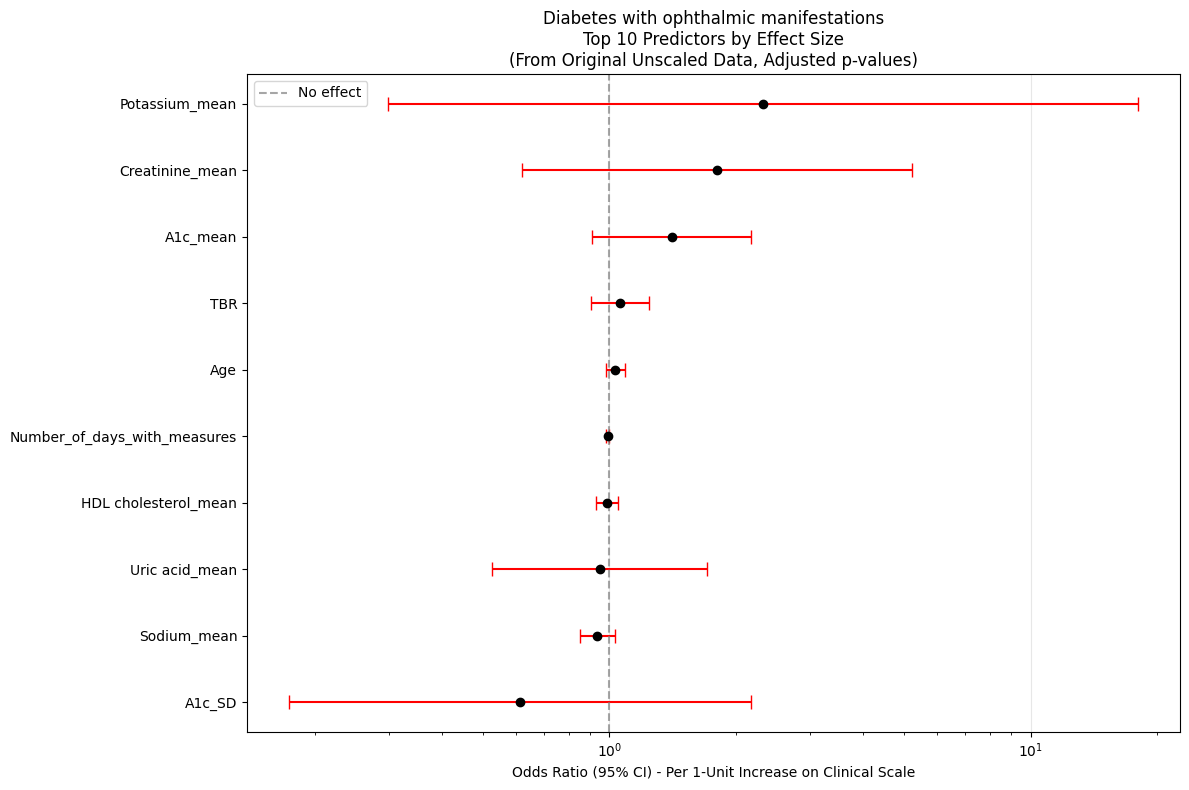


ANALYSIS FOR: LIPID METABOLISM
Applied SMOTE: Training samples for prediction model: 898
Original training samples preserved for inference: 485

Original training samples: 485
Prediction training samples (after SMOTE): 898
Test samples: 208
Class distribution (original train): {0: np.int64(449), 1: np.int64(36)}
Class distribution (SMOTE train): {0: np.int64(449), 1: np.int64(449)}

[1/4] Calculating odds ratios on ORIGINAL UNSCALED training data...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.20546092872461047
            Iterations: 165
            Function evaluations: 207
            Gradient evaluations: 165

*** ODDS RATIOS INTERPRETATION ***
These odds ratios represent the multiplicative change in odds
for a 1-UNIT increase in each feature on its ORIGINAL CLINICAL SCALE.
Example: If Age has OR=1.05, each additional year increases odds by 5%

IMPORTANT METHODOLOGICAL NOTES:
- Calculated on ORIGINAL data (pre-SMOTE) for valid inferen

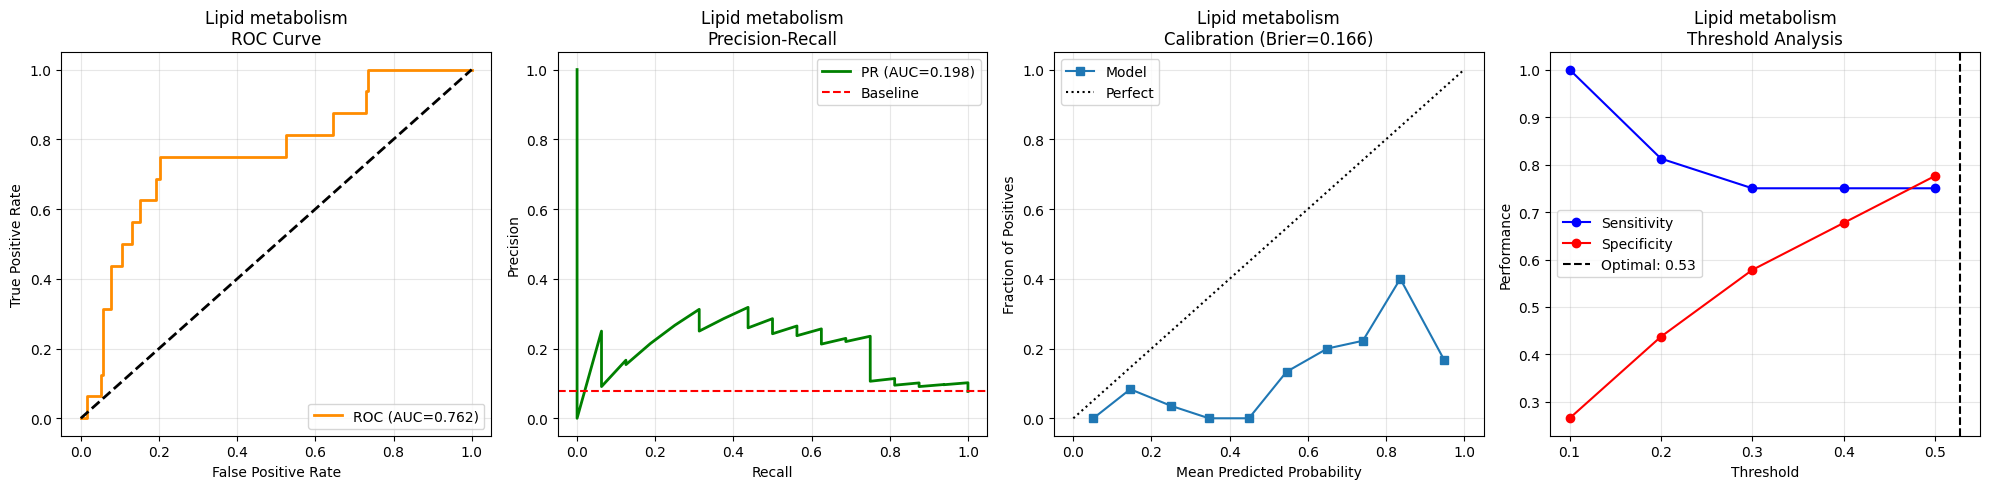

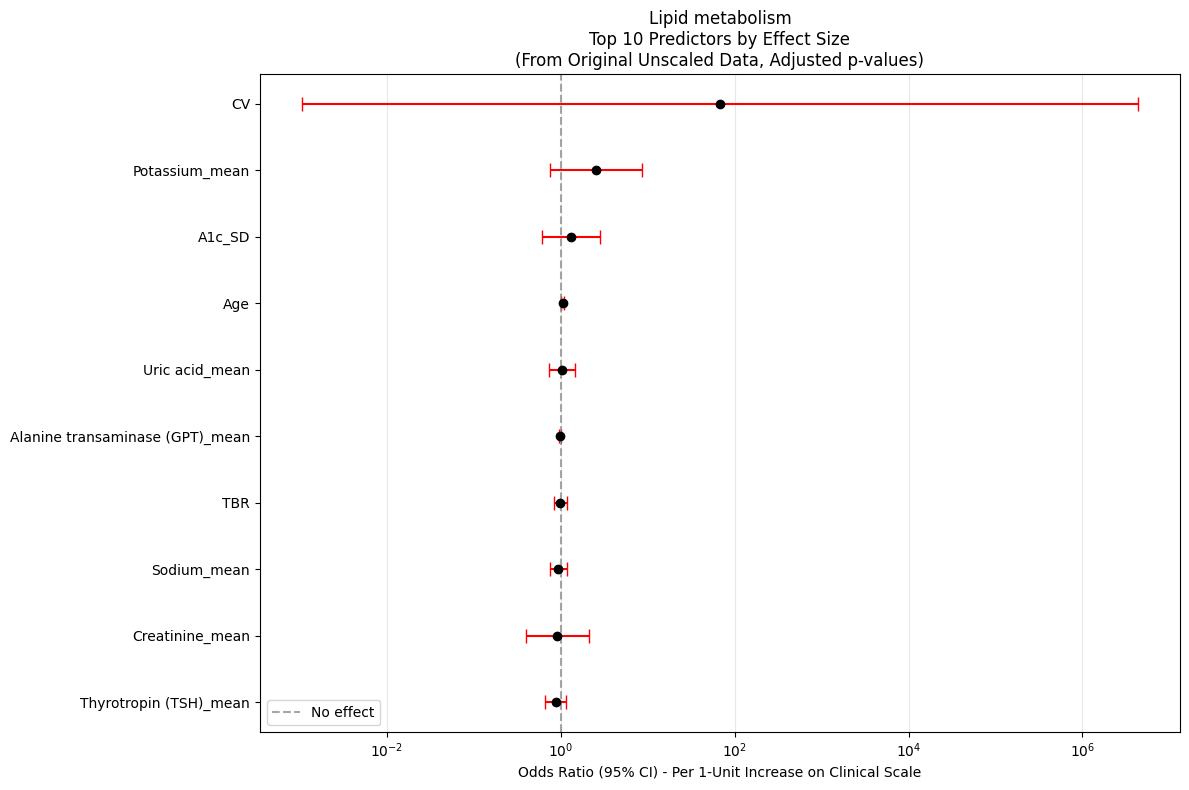

In [31]:
# Define conditions to analyze
conditions = [
    'Hypothyroidism',
    'Hypertension',
    'Diabetes with ophthalmic manifestations',
    'Lipid metabolism'
]

# Store results for all conditions
results = {}

# Run analysis for each condition
for cond in conditions:
    results[cond] = run_analysis(
        df_complete, 
        cond, 
        apply_smote=True,
        multiple_testing_correction='fdr_bh'  # FDR correction
    )